In [63]:
import keras
# from tensorflow.python.keras.models import KerasTextClassifier
from models import KerasTextClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import os
#print(os.getcwd())
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.metrics import f1_score, classification_report, accuracy_score
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
import csv
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences

# Adding None Relation Type ,Getting all sentences and the relations, Transforming the ConeLL Dataset

In [55]:
def getDocuments(filename):
    rows = []
    row_tuples = []
    documents = []
    with open (filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            rows.append(line.split('\t'))


    for row in rows:
        if len(row) > 2:
            row_tuples.append(row)
        else:
            if len(row_tuples) > 0:
                documents.append(row_tuples)
                row_tuples = []

    documents.append(row_tuples)
    return documents
        

#Forming Entity pairs along with their relations. (It can be None as well)
# { 0: ([‘lives_in’,’works_for’],[0,4,8])}

def getRelations(documents):
    document_relations = dict()
    for j , document in enumerate(documents):
        indexes_of_sentence = []
        relations_of_sentence = []

        for i,row_tuple in enumerate(document):
            #Considering only those words that are entities defined by our Base Classifier
            if row_tuple[2] != 'O':
                x = row_tuple[3].strip('\[\]')
                #If statement for incorporating the Relations other than None.
                if x[1:-1] != 'N':
                    index_of_sentence = []

                    start = i
                    end_of_sentences = row_tuple[4][1:-2].split(',')
                    index_of_sentence =  [start] + end_of_sentences

                    relations = x.split(',')

                    if j not in document_relations.keys():
                        document_relations[j] = [(relations, index_of_sentence)]
                    else:
                        document_relations[j].append((relations, index_of_sentence))
                else:
                #Incorporating the None relations

                    if row_tuple[2][0] == 'B':
                        start_index = i + 1
                        #Mapping the None relations I to I 
                        while start_index < len(document) and document[start_index][2][0] == 'I':
                            start_index= start_index + 1
                        start_index = start_index - 1
                        x = document[start_index][3].strip('\[\]')

                        if x.strip('\'') == 'N':

                            index_of_sentence = []
                            start = start_index
                            end_of_sentences = []
                            relations = []
                            for k in range(i+1,len(document)):
                                if document[k][2] != 'O' and document[k][2][0] == 'B':
                                    start_index = k + 1
                                    while start_index < len(document) and document[start_index][2][0] == 'I' :
                                        start_index= start_index + 1

                                    start_index = start_index -1 

                                    if str(start) not in document[start_index][4][1:-2].split(','): 
                                        end_of_sentences.append(start_index)
                                        relations.append('None')


                            index_of_sentence =  [start] + end_of_sentences

                            if len(relations) != 0:
    #                             print('The index of sentences are:',index_of_sentence)
                                if j not in document_relations.keys():
                                    document_relations[j] = [(relations, index_of_sentence)]
                                else:
                                    document_relations[j].append((relations, index_of_sentence))
    #print(document_relations)
                            
    return document_relations

# print(document_relations)
def getGoldTruth(document_relations,documents):
    
    gold_truths = dict()
    #dictionary of {(0,2,3):"Live_In"} 0 : is the document Number, 2,3 are the tokens in the sentence that are related by this relation which is the value of the dictionary.
    total_sentences = list()
    total_relations = []
     #Finally we annotate the sentences as per the requirement of our ML Model(BiLSTM Layer)
    for key,value in document_relations.items():
        for rel_tuple in value:
            start = rel_tuple[1][0]
            for j,relation in enumerate(rel_tuple[0]):
                end = int(rel_tuple[1][j+1])
                if start > end:
                    start ,end = end ,start

                total_relations.append(relation.strip().strip('\"').strip('\''))
                sentence = ''

                for k in range(0,len(documents[key])):

                    if int(documents[key][k][0]) == int(start) or int(documents[key][k][0]) == int(end) :
                        start_tag = '<'+ documents[key][k][2] + '>'
                        end_tag = '</'+ documents[key][k][2] + '> '
                        sentence = sentence + start_tag + documents[key][k][1] + end_tag
                    else:  
                        sentence = sentence + documents[key][k][1] + ' '

                gold_truths[(key,start,end)] = relation.strip().strip('\"').strip('\'')
                total_sentences.append(sentence)

    #print(total_relations)
    #print(total_sentences)
    n_relations = len(set(total_relations))
    return (gold_truths,total_relations,total_sentences)


documents_test = getDocuments('test.txt')    
documents_train = getDocuments('train.txt')

relations_test = getRelations(documents_test)
relations_train = getRelations(documents_train)

gold_truths_test,tr_te,ts_te = getGoldTruth(relations_test,documents_test)
gold_truths_train,tr_tr,ts_tr = getGoldTruth(relations_train,documents_train)

#print(gold_truths_test)
#print(gold_truths_train)

In [56]:
n_relations = len(set(tr_tr))
print("Found {} relations\n".format(n_relations))
print("Relations:\n{}".format(list(set(tr_tr))))

Found 6 relations

Relations:
['None', 'Work_For', 'Live_In', 'Located_In', 'OrgBased_In', 'Kill']


# Transformed our CoNLL dataset accordingly

In [12]:
kclf = KerasTextClassifier(input_length=50, n_classes=n_relations, max_words=15000)
tr_sent, te_sent, tr_rel, te_rel = train_test_split(ts_tr, tr_tr, test_size=0.1)
kclf.fit(X=tr_sent, y=tr_rel, X_val=te_sent, y_val=te_rel,
         batch_size=64, lr=0.001, epochs=50)

kclf.save_model()
kclf.save()

Fit text model with 6 classes


/home/shalaka/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5632 samples, validate on 626 samples
Epoch 1/50
5632/5632 [==============================] - 8s 1ms/step - loss: 1.0261 - accuracy: 0.7333 - val_loss: 0.9431 - val_accuracy: 0.7252
Epoch 2/50
5632/5632 [==============================] - 6s 1ms/step - loss: 0.9080 - accuracy: 0.7431 - val_loss: 0.8875 - val_accuracy: 0.7284
Epoch 3/50
5632/5632 [==============================] - 6s 1ms/step - loss: 0.8518 - accuracy: 0.7472 - val_loss: 0.8350 - val_accuracy: 0.7364
Epoch 4/50
5632/5632 [==============================] - 7s 1ms/step - loss: 0.8134 - accuracy: 0.7530 - val_loss: 0.8101 - val_accuracy: 0.7380
Epoch 5/50
5632/5632 [==============================] - 7s 1ms/step - loss: 0.7689 - accuracy: 0.7587 - val_loss: 0.7845 - val_accuracy: 0.7444
Epoch 6/50
5632/5632 [==============================] - 8s 1ms/step - loss: 0.7420 - accuracy: 0.7619 - val_loss: 0.7728 - val_accuracy: 0.7508
Epoch 7/50
5632/5632 [==============================] - 8s 1ms/step - loss: 0.7097 - accu

In [57]:
kclf = KerasTextClassifier(input_length=50, n_classes=n_relations, max_words=15000)
kclf.load()

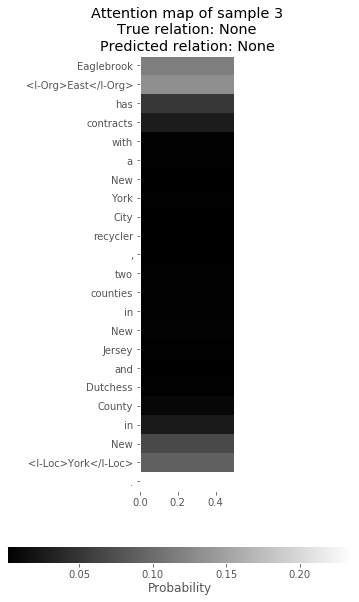

In [41]:
# # kclf.load_SavedModel()
# y_pred = kclf.predict(te_sent)
# y_attn = kclf._get_attention_map(te_sent)

# i = 3
# activation_map = np.expand_dims(y_attn[i][:len(te_sent[i].split())], axis=1)

# f = plt.figure(figsize=(8, 8))
# ax = f.add_subplot(1, 1, 1)

# img = ax.imshow(activation_map, interpolation='none', cmap='gray')

# plt.xlim([0,0.5])
# ax.set_aspect(0.1)
# ax.set_yticks(range(len(te_sent[i].split())))
# ax.set_yticklabels(te_sent[i].split());
# ax.grid()
# plt.title("Attention map of sample {}\nTrue relation: {}\nPredicted relation: {}"
#           .format(i, te_rel[i], kclf.encoder.classes_[y_pred[i]]));

# # add colorbar
# cbaxes = f.add_axes([0.2, 0, 0.6, 0.03]);
# cbar = f.colorbar(img, cax=cbaxes, orientation='horizontal');
# cbar.ax.set_xlabel('Probability', labelpad=2);

In [59]:
def getGoldTruth(sentenceID,indexes):
    
    if (sentenceID,indexes[0],indexes[1]) not in gold_truths_test:
        return "None"
    return gold_truths_test[(sentenceID,indexes[0],indexes[1])]

In [58]:
def model_predict(input_sentences,gold_indexes,sentenceID):
#     kclf = KerasTextClassifier(input_length=50, n_classes=56, max_words=15000)
#     kclf.load_SavedModel()
    y_test_pred = kclf.predict(input_sentences)


    label_idx_to_use = [i for i, c in enumerate(list(kclf.encoder.classes_)) if  c !="Other"]
    label_to_use = list(kclf.encoder.classes_)


    print("{:20}||{:20}".format("Sentence",'Predicted'))
    for i in range(0,len(y_test_pred)):
        print("{:20}||{:20}".format(input_sentences[i], label_to_use[y_test_pred[i]]))
    return (y_test_pred)

In [35]:
# print(te_sent)

# y_test_pred = kclf.predict(te_sent)
# print(np.array(te_sent).shape)
# print(y_test_pred)

# label_idx_to_use = [i for i, c in enumerate(list(kclf.encoder.classes_)) if  c !="Other"]
# label_to_use = list(kclf.encoder.classes_)


# print(label_to_use)
# print(np.array(label_to_use).shape)

# print(np.array(y_test_pred).shape)
# print(np.array(te_sent).shape)


# print("{:20}||{:20}||{:20}".format("Sentence", "Actual",'Predicted'))
# count = 0

# for i in range(0,len(y_test_pred)):
#     if label_to_use[y_test_pred[i]] == te_rel[i]:
#         count = count + 1
#         print("{:20}||{:20}||{:20}".format(te_sent[i], label_to_use[y_test_pred[i]],te_rel[i]))
# print('The total correct results',count)
# print(len(y_test_pred))
# print("F1-Score: {:.1%}".format(f1_score(kclf.encoder.transform(te_rel), y_test_pred,average="macro", labels=label_idx_to_use)))

# print(classification_report(kclf.encoder.transform(te_rel), y_test_pred,
#                             target_names=label_to_use,
#                             labels=label_idx_to_use))

In [36]:
# words = [tr_sent[0]]
# tokenizer = Tokenizer(num_words=100, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token="UNK")
# tokenizer.fit_on_texts(words)
# print(tokenizer.word_index.items())
# tokenizer.word_index = {e: i for e,i in tokenizer.word_index.items() if i <= 100}
# print(tokenizer.word_index)
# # self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1

In [37]:
# def _get_sequences(texts):
#         seqs = tokenizer.texts_to_sequences(texts)
#         return pad_sequences(seqs, maxlen=100,
#                              value=0, padding='post', truncating='post')

In [60]:
 def getIndexes(data,column,pointer):
    indexes = []
    input_words = []
    input_tags_all = []
    input_sentences = []
    input_tags_not_other =[]
    j=0;
    for i in range(pointer,pointer+len(data['Word'])):
        input_words.append(data['Word'][i])
        input_tags_all.append(data[column][i])
        if data[column][i] != 'O':
            input_tags_not_other.append((j,data[column][i]))
        j = j + 1

    flag = 0
    for i in range(0,len(input_tags_not_other)):
        for j in range(i+1,len(input_tags_not_other)):
            if input_tags_not_other[i][1][0] == 'B' and input_tags_not_other[j][1][0] == 'B':
                flag = 0
                
                start1 = i + 1 
                while start1< len(input_tags_not_other) and input_tags_not_other[start1][1][0] == 'I':
                    start1 = start1 + 1 
                    flag = 1
                
                start1 = start1 - 1
                start2 = j + 1
                while start2 < len(input_tags_not_other) and input_tags_not_other[start2][1][0] == 'I':
                    start2 = start2 + 1 
                    flag = 1
                
                start2 = start2 - 1 
                print(input_tags_not_other[start1][0],input_tags_not_other[start2][0])
                if  start1 != start2:
                    indexes.append((input_tags_not_other[start1][0],input_tags_not_other[start2][0]))
                    
                    
                    
    for index in indexes:
        start = index[0]
        end = index[1]
        input_sentence = ''
        for j,word in enumerate(input_words):
            if j  == start or j  == end:
                start_tag = '<'+ input_tags_all[j]+'>'
                end_tag = '</'+ input_tags_all[j]+'> '
                input_sentence = input_sentence + start_tag + word + end_tag
            else:
                input_sentence = input_sentence + word + ' '
        input_sentences.append(input_sentence)   

    print(input_sentences)
        
    return input_sentences,indexes
   

# Testing Relation Classifier

In [61]:
if __name__ == '__main__':
    pointer = 0;
    data = pd.read_csv('base_classifier_test.csv')
    print(label_to_use)
    with open('relation_classifier_sample.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["SentenceID","token1","token2","Sentence","Predicted","Gold Truth"])
        for sentenceID in range(0,288):
            input_sentences = []
            gold_truth_indexes =[] 
            data_to_send = data.loc[data['SentenceID'] == sentenceID+1]
            print(data_to_send)
            input_sentences,gold_truth_indexes = getIndexes(data_to_send,"Gold Truth",pointer)
            pointer = pointer + len(data_to_send['Word'])
            print(input_sentences)
            if len(gold_truth_indexes) > 0:
                y_test_pred = model_predict(input_sentences,gold_truth_indexes,sentenceID)
                for i in range(0,len(y_test_pred)):
                    writer.writerow([sentenceID+1,gold_truth_indexes[i][0],gold_truth_indexes[i][1],
                input_sentences[i],label_to_use[y_test_pred[i]],getGoldTruth(sentenceID,gold_truth_indexes[i])])


['Kill', 'Live_In', 'Located_In', 'None', 'OrgBased_In', 'Work_For']
    SentenceID  tokenID        Word Predicted Gold Truth
0            1        1          On         O          O
1            1        2       April   B-Other    B-Other
2            1        3          14         O          O
3            1        4           ,         O          O
4            1        5       while         O          O
5            1        6   attending         O          O
6            1        7           a         O          O
7            1        8        play         O          O
8            1        9          at         O          O
9            1       10         the         O          O
10           1       11        Ford     B-Org      B-Org
11           1       12     Theatre     I-Org      I-Org
12           1       13          in         O          O
13           1       14  Washington     B-Loc      B-Loc
14           1       15           ,         O          O
15           1     

Sentence            ||Predicted           
On <B-Other>April</B-Other> 14 , while attending a play at the Ford <I-Org>Theatre</I-Org> in Washington , Lincoln was shot in the head by actor John Wilkes Booth , who cried out ` ` Sic Semper Tyranus ' ' ( ` ` Thus Ever to Tyrants , ' ' the motto of ||None                
On <B-Other>April</B-Other> 14 , while attending a play at the Ford Theatre in <B-Loc>Washington</B-Loc> , Lincoln was shot in the head by actor John Wilkes Booth , who cried out ` ` Sic Semper Tyranus ' ' ( ` ` Thus Ever to Tyrants , ' ' the motto of ||None                
On <B-Other>April</B-Other> 14 , while attending a play at the Ford Theatre in Washington , <B-Peop>Lincoln</B-Peop> was shot in the head by actor John Wilkes Booth , who cried out ` ` Sic Semper Tyranus ' ' ( ` ` Thus Ever to Tyrants , ' ' the motto of ||None                
On <B-Other>April</B-Other> 14 , while attending a play at the Ford Theatre in Washington , Lincoln was shot in the head by actor 

Sentence            ||Predicted           
Sirhan B. Sirhan , who shot Sen. Robert F. <I-Peop>Kennedy</I-Peop> to death 22 years ago , was denied parole <B-Other>Tuesday</B-Other> for the 13th time . ||None                
     SentenceID  tokenID        Word Predicted Gold Truth
530          18        1     Vaughan     B-Loc     B-Peop
531          18        2           ,         O          O
532          18        3           a         O          O
533          18        4         dog         O          O
534          18        5      musher         O          O
535          18        6         and         O          O
536          18        7        Army     B-Org          O
537          18        8         Air     I-Org      B-Org
538          18        9       Force     I-Org      I-Org
539          18       10     officer         O          O
540          18       11           ,         O          O
541          18       12         was         O          O
542          18       1

     SentenceID  tokenID     Word Predicted Gold Truth
967          32        1     Mark    B-Peop     B-Peop
968          32        2    David    I-Peop     I-Peop
969          32        3  Chapman    I-Peop     I-Peop
970          32        4     says         O          O
971          32        5     that         O          O
972          32        6       he         O          O
973          32        7    feels         O          O
974          32        8    great         O          O
975          32        9  remorse         O          O
976          32       10      for         O          O
977          32       11  killing         O          O
978          32       12     John    B-Peop     B-Peop
979          32       13   Lennon    I-Peop     I-Peop
980          32       14      but         O          O
981          32       15     that         O          O
982          32       16      the         O          O
983          32       17  slaying         O          O
984       

      SentenceID  tokenID          Word Predicted Gold Truth
1474          46        1           The         O          O
1475          46        2   Sandinistas     B-Loc          O
1476          46        3       renamed         O          O
1477          46        4           the         O          O
1478          46        5       stadium         O          O
1479          46        6         after         O          O
1480          46        7     Rigoberto    B-Peop     B-Peop
1481          46        8         Lopez    I-Peop     I-Peop
1482          46        9         Perez    I-Peop     I-Peop
1483          46       10             ,         O          O
1484          46       11             a         O          O
1485          46       12        tailor         O          O
1486          46       13           and         O          O
1487          46       14          poet         O          O
1488          46       15           who         O          O
1489          46       1

Sentence            ||Predicted           
AU2405185594 <B-Loc>Chisinau</B-Loc> <B-Org>BASAPRESS</B-Org> in English 1750 GMT 23 May 94 ||OrgBased_In         
AU2405185594 <B-Loc>Chisinau</B-Loc> BASAPRESS in English 1750 <I-Other>GMT</I-Other> 23 May 94 ||None                
AU2405185594 <B-Loc>Chisinau</B-Loc> BASAPRESS in English 1750 GMT 23 May <I-Other>94</I-Other> ||None                
AU2405185594 Chisinau <B-Org>BASAPRESS</B-Org> in English 1750 <I-Other>GMT</I-Other> 23 May 94 ||None                
AU2405185594 Chisinau <B-Org>BASAPRESS</B-Org> in English 1750 GMT 23 May <I-Other>94</I-Other> ||None                
AU2405185594 Chisinau BASAPRESS in English 1750 <I-Other>GMT</I-Other> 23 May <I-Other>94</I-Other> ||None                
      SentenceID  tokenID        Word Predicted Gold Truth
1924          64        1           (         O          O
1925          64        2     Article         O          O
1926          64        3          by         O          O
1927   

      SentenceID  tokenID           Word Predicted Gold Truth
2351          80        1             In         O          O
2352          80        2        Beijing    B-Peop      B-Loc
2353          80        3       Thursday    I-Peop          O
2354          80        4              ,         O          O
2355          80        5      spokesman         O          O
2356          80        6             Li    B-Peop     B-Peop
2357          80        7       repeated         O          O
2358          80        8          China    B-Peop      B-Loc
2359          80        9             's         O          O
2360          80       10       position         O          O
2361          80       11           that         O          O
2362          80       12            the         O          O
2363          80       13            key         O          O
2364          80       14             to         O          O
2365          80       15            the         O          O
2366    

      SentenceID  tokenID        Word Predicted Gold Truth
2776          96        1          In         O          O
2777          96        2        1801         O          O
2778          96        3           ,         O      I-Loc
2779          96        4      Mormon     B-Loc      B-Org
2780          96        5      leader         O          O
2781          96        6     Brigham    B-Peop     B-Peop
2782          96        7       Young    I-Peop     I-Peop
2783          96        8         was         O          O
2784          96        9        born         O          O
2785          96       10          in         O          O
2786          96       11  Whitingham     B-Loc      B-Loc
2787          96       12           ,     I-Loc      I-Loc
2788          96       13          Vt     I-Loc      I-Loc
2789          96       14           .         O          O
3 6
3 12
6 12
['In 1801 , <B-Org>Mormon</B-Org> leader Brigham <I-Peop>Young</I-Peop> was born in Whitingham , Vt .

      SentenceID  tokenID       Word Predicted Gold Truth
3195         114        1    Atwater         O     B-Peop
3196         114        2          ,         O          O
3197         114        3         37         O          O
3198         114        4          ,         O          O
3199         114        5         is         O          O
3200         114        6          a         O          O
3201         114        7      South     B-Loc      B-Loc
3202         114        8   Carolina     I-Loc      I-Loc
3203         114        9     native         O          O
3204         114       10        who         O          O
3205         114       11    earlier         O          O
3206         114       12     served         O          O
3207         114       13         as         O          O
3208         114       14         an         O          O
3209         114       15       aide         O          O
3210         114       16         to         O          O
3211         1

      SentenceID  tokenID       Word Predicted Gold Truth
3593         128        1         In         O          O
3594         128        2       1822         O          O
3595         128        3          ,         O      I-Loc
3596         128        4        the         O          O
3597         128        5       18th         O          O
3598         128        6  president         O          O
3599         128        7         of         O          O
3600         128        8        the         O          O
3601         128        9     United     B-Loc      B-Loc
3602         128       10     States     I-Loc      I-Loc
3603         128       11          ,         O      I-Loc
3604         128       12    Ulysses    B-Peop     B-Peop
3605         128       13         S.    I-Peop     I-Peop
3606         128       14      Grant    I-Peop     I-Peop
3607         128       15          ,         O      I-Loc
3608         128       16        was         O          O
3609         1

Sentence            ||Predicted           
Today 's highlight in history : On Jan. 8 , 1935 <I-Loc>,</I-Loc> rock 'n ' roll legend Elvis <I-Peop>Presley</I-Peop> was born in Tupelo , Miss . ||Located_In          
Today 's highlight in history : On Jan. 8 , 1935 <I-Loc>,</I-Loc> rock 'n ' roll legend Elvis Presley was born in Tupelo , <I-Loc>Miss</I-Loc> . ||Located_In          
Today 's highlight in history : On Jan. 8 , 1935 , rock 'n ' roll legend Elvis <I-Peop>Presley</I-Peop> was born in Tupelo , <I-Loc>Miss</I-Loc> . ||Live_In             
      SentenceID  tokenID               Word Predicted Gold Truth
4073         145        1                For         O          O
4074         145        2              extra         O          O
4075         145        3             credit         O          O
4076         145        4                  ,         O          O
4077         145        5             Shutes    B-Peop     B-Peop
4078         145        6              noted         

      SentenceID  tokenID       Word Predicted Gold Truth
4429         158        1         In         O          O
4430         158        2       1831         O          O
4431         158        3          ,         O      I-Loc
4432         158        4        the         O          O
4433         158        5       20th         O          O
4434         158        6  president         O          O
4435         158        7         of         O          O
4436         158        8        the         O          O
4437         158        9     United     B-Loc      B-Loc
4438         158       10     States     I-Loc      I-Loc
4439         158       11          ,         O      I-Loc
4440         158       12      James    B-Peop     B-Peop
4441         158       13   Garfield    I-Peop     I-Peop
4442         158       14          ,         O      I-Loc
4443         158       15        was         O          O
4444         158       16       born         O          O
4445         1

      SentenceID  tokenID                 Word Predicted Gold Truth
4661         166        1                Terry    B-Peop     B-Peop
4662         166        2                Hands    I-Peop     I-Peop
4663         166        3                    ,         O          O
4664         166        4                  the         O          O
4665         166        5           subsidized         O          O
4666         166        6              theater         O          O
4667         166        7                   's         O          O
4668         166        8             artistic         O          O
4669         166        9             director         O          O
4670         166       10                    ,         O          O
4671         166       11             unveiled         O          O
4672         166       12                    a         O          O
4673         166       13                  new         O          O
4674         166       14                    `  

Sentence            ||Predicted           
Security Forces Widen Ban on Possession of Arms NC0302223394 <B-Loc>Paris</B-Loc> <B-Org>AFP</B-Org> in English 2200 GMT 3 Feb 94 ||OrgBased_In         
Security Forces Widen Ban on Possession of Arms NC0302223394 <B-Loc>Paris</B-Loc> AFP in English 2200 <I-Other>GMT</I-Other> 3 Feb 94 ||None                
Security Forces Widen Ban on Possession of Arms NC0302223394 <B-Loc>Paris</B-Loc> AFP in English 2200 GMT 3 Feb <I-Other>94</I-Other> ||None                
Security Forces Widen Ban on Possession of Arms NC0302223394 Paris <B-Org>AFP</B-Org> in English 2200 <I-Other>GMT</I-Other> 3 Feb 94 ||None                
Security Forces Widen Ban on Possession of Arms NC0302223394 Paris <B-Org>AFP</B-Org> in English 2200 GMT 3 Feb <I-Other>94</I-Other> ||None                
Security Forces Widen Ban on Possession of Arms NC0302223394 Paris AFP in English 2200 <I-Other>GMT</I-Other> 3 Feb <I-Other>94</I-Other> ||None                
      SentenceI

      SentenceID  tokenID       Word Predicted Gold Truth
5456         196        1    Heavier         O          O
5457         196        2   rainfall         O          O
5458         196        3     during         O          O
5459         196        4        the         O          O
5460         196        5        six         O          O
5461         196        6      hours         O          O
5462         196        7     ending         O          O
5463         196        8         at         O          O
5464         196        9          2   B-Other    B-Other
5465         196       10       p.m.         O    I-Other
5466         196       11        EDT   I-Other    I-Other
5467         196       12   included         O          O
5468         196       13     nearly         O          O
5469         196       14          7         O    B-Other
5470         196       15          -         O    I-Other
5471         196       16     inches         O          O
5472         1

      SentenceID  tokenID                   Word Predicted Gold Truth
5811         212        1                      `         O          O
5812         212        2                      `         O          O
5813         212        3                    NRC         O      B-Org
5814         212        4                    has         O          O
5815         212        5                      a         O          O
5816         212        6                  broad         O          O
5817         212        7           programmatic         O          O
5818         212        8                concern         O          O
5819         212        9                   that         O          O
5820         212       10                    the         O          O
5821         212       11               pressure         O          O
5822         212       12                     to         O          O
5823         212       13                   meet         O          O
5824         212    

Sentence            ||Predicted           
On Monday , one man was lost from an oil rig off Grand <I-Loc>Isle</I-Loc> , <B-Loc>La.</B-Loc> , as the storm moved in . ||Located_In          
      SentenceID  tokenID        Word Predicted Gold Truth
6295         227        1      During         O          O
6296         227        2        that         O          O
6297         227        3        time         O          O
6298         227        4           ,         O          O
6299         227        5          an         O          O
6300         227        6   estimated         O          O
6301         227        7           2   B-Other    B-Other
6302         227        8     million   I-Other    I-Other
6303         227        9          of         O          O
6304         227       10    Cambodia     B-Loc      B-Loc
6305         227       11          's         O          O
6306         227       12           8         O    B-Other
6307         227       13     million   I-Oth

1 13
1 18
1 21
1 29
13 18
13 21
13 29
18 21
18 29
21 29
['In <B-Loc>Dallas</B-Loc> , preparations continue for a museum at the Texas School Book <I-Org>Depository</I-Org> where assassin Lee Harvey Oswald gunned down Kennedy as the presidential motorcade rode through Dealey Plaza . ', 'In <B-Loc>Dallas</B-Loc> , preparations continue for a museum at the Texas School Book Depository where assassin Lee Harvey <I-Peop>Oswald</I-Peop> gunned down Kennedy as the presidential motorcade rode through Dealey Plaza . ', 'In <B-Loc>Dallas</B-Loc> , preparations continue for a museum at the Texas School Book Depository where assassin Lee Harvey Oswald gunned down <B-Peop>Kennedy</B-Peop> as the presidential motorcade rode through Dealey Plaza . ', 'In <B-Loc>Dallas</B-Loc> , preparations continue for a museum at the Texas School Book Depository where assassin Lee Harvey Oswald gunned down Kennedy as the presidential motorcade rode through Dealey <I-Loc>Plaza</I-Loc> . ', 'In Dallas , preparations c

Sentence            ||Predicted           
The real lucky duck was Tom <I-Peop>Defelice</I-Peop> of <B-Loc>Warwick</B-Loc> , who won a vacation for four at Disney World in Florida after his duck crossed the finish line first in 51 : 15 . ||Live_In             
The real lucky duck was Tom <I-Peop>Defelice</I-Peop> of Warwick , who won a vacation for four at Disney <I-Loc>World</I-Loc> in Florida after his duck crossed the finish line first in 51 : 15 . ||Live_In             
The real lucky duck was Tom <I-Peop>Defelice</I-Peop> of Warwick , who won a vacation for four at Disney World in <B-Loc>Florida</B-Loc> after his duck crossed the finish line first in 51 : 15 . ||Live_In             
The real lucky duck was Tom Defelice of <B-Loc>Warwick</B-Loc> , who won a vacation for four at Disney <I-Loc>World</I-Loc> in Florida after his duck crossed the finish line first in 51 : 15 . ||Located_In          
The real lucky duck was Tom Defelice of <B-Loc>Warwick</B-Loc> , who won a vacation for

Sentence            ||Predicted           
In <B-Other>1985</B-Other> , shuttle passengers included Sultan <I-Peop>Al-Saud</I-Peop> of Saudi Arabia and Rodolfo Neri Vela , a Mexican . ||None                
In <B-Other>1985</B-Other> , shuttle passengers included Sultan Al-Saud of Saudi <I-Loc>Arabia</I-Loc> and Rodolfo Neri Vela , a Mexican . ||None                
In <B-Other>1985</B-Other> , shuttle passengers included Sultan Al-Saud of Saudi Arabia and Rodolfo Neri <I-Peop>Vela</I-Peop> , a Mexican . ||None                
In <B-Other>1985</B-Other> , shuttle passengers included Sultan Al-Saud of Saudi Arabia and Rodolfo Neri Vela , a <B-Other>Mexican</B-Other> . ||None                
In 1985 , shuttle passengers included Sultan <I-Peop>Al-Saud</I-Peop> of Saudi <I-Loc>Arabia</I-Loc> and Rodolfo Neri Vela , a Mexican . ||Live_In             
In 1985 , shuttle passengers included Sultan <I-Peop>Al-Saud</I-Peop> of Saudi Arabia and Rodolfo Neri <I-Peop>Vela</I-Peop> , a Mexican . ||

In [51]:
#  != print(np.array(tr_sent).shape)
# print(np.array(tr_rel).shape)
# print(np.array(te_sent).shape)
# print(np.array(te_rel).shape)

In [43]:
print(input_sentences)
print(ts_tr[:6])

if input_sentences[2] != ts_tr[2]:
    print("hii")

['In <B-Loc>Washington</B-Loc> state , an 850-acre fire burning in the <B-Loc>Cascade</B-Loc> range near the Canadian border was 84 percent contained Tuesday , said Greg Thayer of the U.S. Forest Service . ', 'In <B-Loc>Washington</B-Loc> state , an 850-acre fire burning in the Cascade range near the Canadian border was 84 <I-Other>percent</I-Other> contained Tuesday , said Greg Thayer of the U.S. Forest Service . ', 'In <B-Loc>Washington</B-Loc> state , an 850-acre fire burning in the Cascade range near the Canadian border was 84 percent contained Tuesday , said Greg <I-Peop>Thayer</I-Peop> of the U.S. Forest Service . ', 'In <B-Loc>Washington</B-Loc> state , an 850-acre fire burning in the Cascade range near the Canadian border was 84 percent contained Tuesday , said Greg Thayer of the U.S. Forest <I-Org>Service</I-Org> . ', 'In Washington state , an 850-acre fire burning in the <B-Loc>Cascade</B-Loc> range near the Canadian border was 84 <I-Other>percent</I-Other> contained Tuesday 